In [1]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [2]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1

In [3]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state


In [4]:
N = 6 #number of sites (easier to apply fermi state to such site)
num_qubits = 2*N + 1

def fermi_state_circuit(N,num_cl_bits = 0):
    list1 = list(range(2*N+1))
    list1.pop(N)
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,reversed(range(N)))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    qc.x(list1)
    return qc

def fermi_state_circuit2(num_qubits,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(int(num_qubits))
    qc.initialize(fermi_state_up,range(int(num_qubits)))
    return qc


def fermion_state(N,pos_list,num_cl_bits = 0):
    qc = QuantumCircuit(2*N+1,num_cl_bits)
    for i in range(2*N+1):
        if i in pos_list or i==N:
            continue
        else:
            qc.x(i)
    return qc





In [5]:
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)

        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

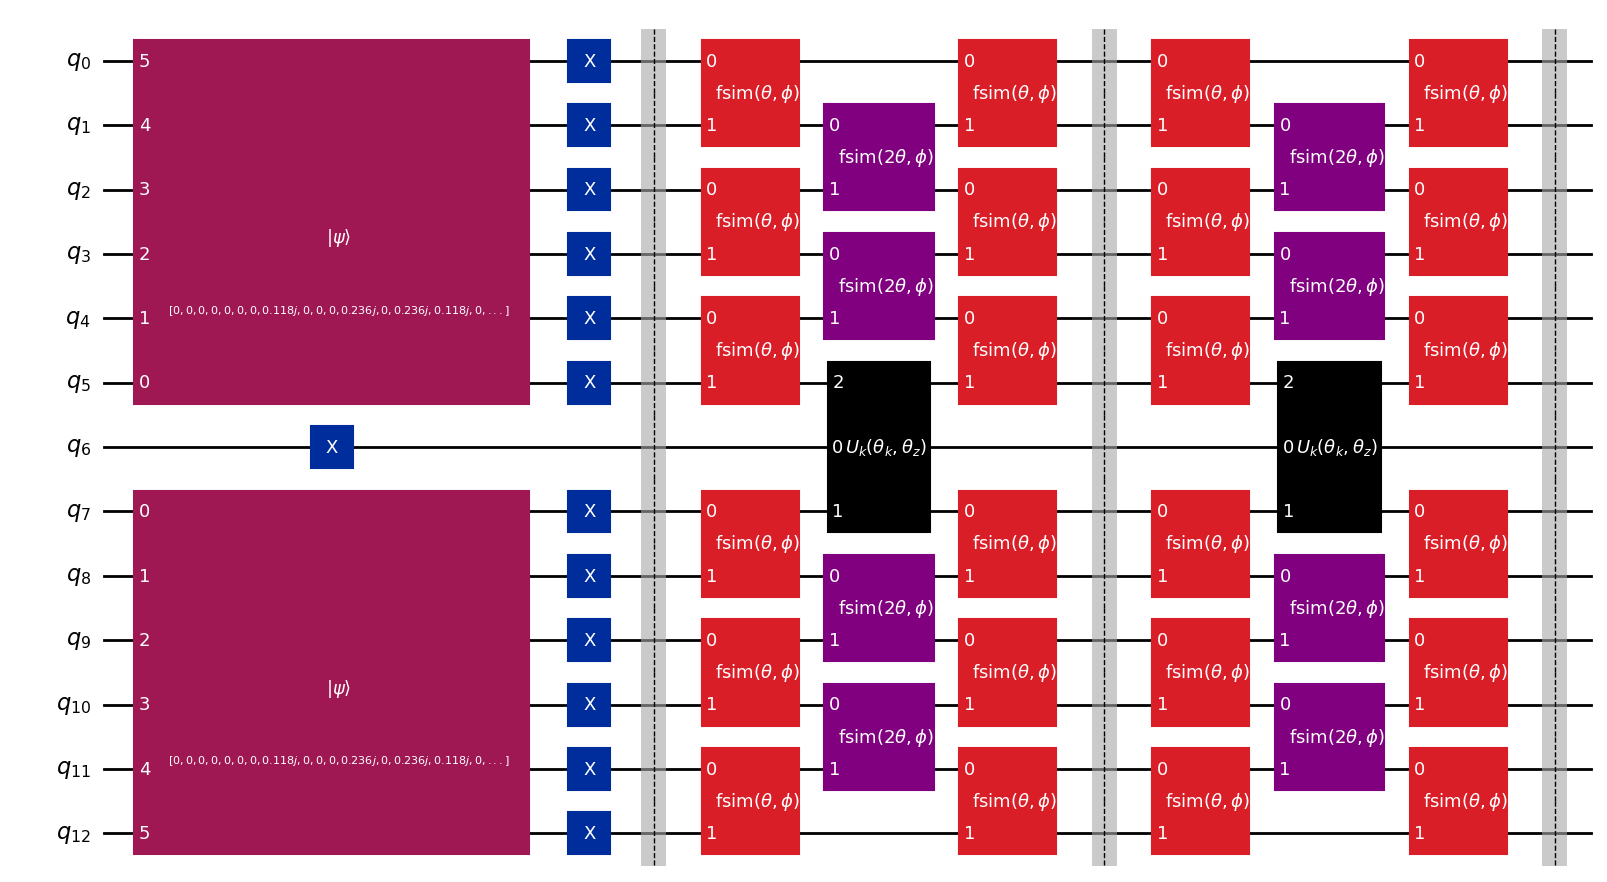

In [6]:
test_trotter_steps = 2
angles = np.pi/4


#Now we add the entire kondo circuit. This is the more efficient layered version as seen in our discussion

# Let us use the direct 8 by 8 unitary now for the problem

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, pos_list, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for i in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)


gate_colours = {
    "displaycolor": {
        r'fsim$(2\theta,\phi)$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(\theta,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$U_{k}(\theta_k,\theta_z)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}
qc.draw(output = 'mpl',style = gate_colours)

In [17]:
#Let us define two qc_lists, with 20 and 50 steps, which will be used later on in different parameter measurements

super_qc_list_20 = []
super_qc_list_50 = []

max_20 = 200
max_50 = 400
measured_bits =list(range(2*N + 1))
theta_list = [np.pi/2]
theta_k_list = [np.pi/4]


for theta in theta_list:
    for theta_k in theta_k_list:
        if theta_k > theta:
            continue
        else:
            theta_z = -theta_k
            qc_list = []
            qc_list_2 = []
            """for t in range(max_20):
                qc = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list.append(qc)
            super_qc_list_20.append((qc_list,theta,theta_k))"""

            for t in range(max_50):
                qc = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list_2.append(qc)
            super_qc_list_50.append((qc_list_2,theta,theta_k))


In [9]:
## The structure is: The first index is a indexing combination of parameters, the second gets a qc_list of 20 or 50 steps, and the third index is the actual qc at time step

qc = super_qc_list_50[2][0][2]
print("Theta is:",super_qc_list_50[2][1])
print("Theta_k is:",super_qc_list_50[2][2])

qc.draw(output = 'mpl',style = gate_colours)

IndexError: list index out of range

In [18]:
## Let us also create a reference theta_super list

theta_super_list = []
for theta in theta_list:
    for theta_k in theta_k_list:
        if theta_k > theta:
            continue
        else:
            theta_super_list.append((theta,theta_k))

print(theta_super_list)

[(1.0471975511965976, 0.7853981633974483)]


In [19]:
estimator = Estimator(approximation=True)
sampler = Sampler()

In [20]:
## Now that we have our circuits with different parameters, we can measure the <H_total> and <S^z_imp> for each of these circuits



def plot_mag_impurity_20(super_qc_list_20):
    for i in range(len(super_qc_list_20)):
        theta = super_qc_list_20[i][1]
        theta_k = super_qc_list_20[i][2]
        qc_list = super_qc_list_20[i][0]
        imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*200
        job_1 = estimator.run(qc_list,imp_observables,shots = None)
        expectation_list_1 = list(job_1.result().values)
        for i in range(200):
            if expectation_list_1[i]  == expectation_list_1[0]:
                print ("Rec time is:",i)
            
            
        plt.plot(range(200),expectation_list_1,label = 'Impurity, {0},{1}'.format(theta,theta_k))
        plt.title(f'Impurity Magnetization for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.xlabel('Time (Trotter Steps)')
        plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
        plt.show()

def plot_mag_impurity_50(super_qc_list_50):
    for i in range(len(super_qc_list_50)):
        theta = super_qc_list_50[i][1]
        theta_k = super_qc_list_50[i][2]
        qc_list = super_qc_list_50[i][0]
        imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*max_50
        job_1 = estimator.run(qc_list,imp_observables,shots = None)
        expectation_list_1 = list(job_1.result().values)
        """c = 0
        for i in range(1,500):
            if abs(expectation_list_1[i]  - expectation_list_1[0]) <= 1e-4:
                c = 1
                print (f"Rec time  for theta = {theta} and theta_k = {theta_k} is:",i)
        if c == 0:
            print(f"Rec time  for theta = {theta} and theta_k = {theta_k} is not found")"""
        print(expectation_list_1)
        plt.plot(range(max_50),expectation_list_1,label = 'Impurity, {0},{1}'.format(theta,theta_k))
        plt.title(f'Impurity Magnetization for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.xlabel('Time (Trotter Steps)')
        plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
        plt.show()

    
    

In [17]:
plot_mag_impurity_20(super_qc_list_20)

[-0.9999999999999999, -0.7500000000000001, -0.5248764640335393, -0.7484150343721097, -0.7509535478039028, -0.5335522274526732, -0.7163460724960886, -0.7471057225898508, -0.6005000568769336, -0.6083076852478134, -0.6673212047144905, -0.6218997785573189, -0.4523355864886036, -0.4863127219766886, -0.574065643459173, -0.4388992279026526, -0.454634206050225, -0.5291219014867544, -0.447248656558302, -0.40046945538609124, -0.3980878518323573, -0.4406239035888858, -0.39972349596088064, -0.4115488118316964, -0.3857726286645758, -0.3640751632180726, -0.3875036877487049, -0.4084713985960642, -0.3708077013940001, -0.3478223526639742, -0.4348723150680697, -0.40599044535137885, -0.3226783607054775, -0.34139791111681794, -0.427002415673056, -0.40344898727987555, -0.3562565041242251, -0.4080743497855107, -0.4123647294402708, -0.34004985467870774, -0.3478717453444735, -0.3524586125816471, -0.2571502788917454, -0.24252627663425158, -0.33913467029287586, -0.3544506674966811, -0.24090137563401234, -0.1884

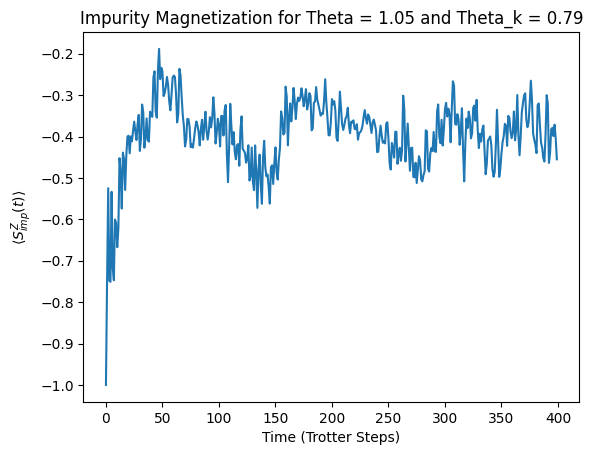

In [21]:
plot_mag_impurity_50(super_qc_list_50)
  #Will take around 45 mins to run

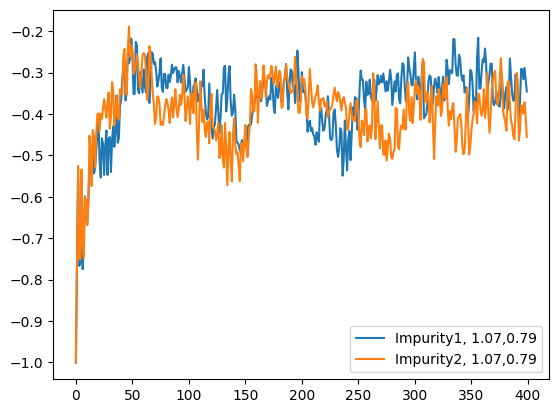

In [22]:
## Check this with saved data

expectation_list_1 = [-0.9999999999999999, -0.7500000000000001, -0.5248764640335393, -0.7484150343721097, -0.7509535478039028, -0.5335522274526732, -0.7163460724960886, -0.7471057225898508, -0.6005000568769336, -0.6083076852478134, -0.6673212047144905, -0.6218997785573189, -0.4523355864886036, -0.4863127219766886, -0.574065643459173, -0.4388992279026526, -0.454634206050225, -0.5291219014867544, -0.447248656558302, -0.40046945538609124, -0.3980878518323573, -0.4406239035888858, -0.39972349596088064, -0.4115488118316964, -0.3857726286645758, -0.3640751632180726, -0.3875036877487049, -0.4084713985960642, -0.3708077013940001, -0.3478223526639742, -0.4348723150680697, -0.40599044535137885, -0.3226783607054775, -0.34139791111681794, -0.427002415673056, -0.40344898727987555, -0.3562565041242251, -0.4080743497855107, -0.4123647294402708, -0.34004985467870774, -0.3478717453444735, -0.3524586125816471, -0.2571502788917454, -0.24252627663425158, -0.33913467029287586, -0.3544506674966811, -0.24090137563401234, -0.18844082600986503, -0.26144842662681944, -0.23400520111654788, -0.243320972241667, -0.3025092789265507, -0.2949376535298508, -0.2798494357208741, -0.25613584865837885, -0.27535944986347644, -0.3152142027787017, -0.33674025758970316, -0.30030330376825654, -0.2577626323161145, -0.252732454898601, -0.25599183906151135, -0.29578973885978876, -0.36588435723483603, -0.3458706837388795, -0.23659337338994402, -0.2527130385560871, -0.30366734784119054, -0.34890038297988374, -0.37571464071683613, -0.4240252679238733, -0.40813015548649323, -0.35741655337368144, -0.35812654301439656, -0.37602535665677905, -0.4258843156217265, -0.4190436061407565, -0.4268498352574073, -0.40289591890402476, -0.38000648273989773, -0.36361194562636334, -0.373289237229141, -0.3894525025287401, -0.42149684629262, -0.3825932936589711, -0.3597057775154788, -0.40768717819268124, -0.3776726216980884, -0.3401700433526537, -0.3857255046329007, -0.40759171826430707, -0.38811164661143477, -0.3533390359931625, -0.3779948550015185, -0.3578350964290857, -0.30531563022317093, -0.34307763237853, -0.41683735817350515, -0.392130428447839, -0.35705925684201406, -0.37275322087685936, -0.42404916156216893, -0.3499770809031915, -0.3506499480652818, -0.39751807125716004, -0.33678778744133464, -0.3238244313650791, -0.4411212187209589, -0.5101365384792891, -0.4249249335265402, -0.32109072829686275, -0.37570517060393366, -0.41917619049352095, -0.3895606632519587, -0.43788247463490404, -0.45504227694432164, -0.4211735400327725, -0.41822582865499747, -0.47073836641596495, -0.3829329671191956, -0.3513509188435151, -0.42998121579823845, -0.4340296887804066, -0.4397415098336411, -0.4632452994769977, -0.45289100983076913, -0.42113477150530804, -0.5063180459897347, -0.4958115417446227, -0.4265044017964649, -0.5085365791315632, -0.5294783990883195, -0.4215283827641041, -0.48536676055176087, -0.5724547178120836, -0.47859467238675285, -0.4437247977757294, -0.516629594799135, -0.5624852281532994, -0.4495295706655711, -0.4104572007899987, -0.4744908833223462, -0.4961627331538504, -0.4917837945866834, -0.5226578761539427, -0.5621924787520166, -0.4739730828553093, -0.46954650640573947, -0.5145603721478718, -0.46449292613085635, -0.4262947787391836, -0.4866393742627935, -0.5039897098545767, -0.4556281864395567, -0.426647422881795, -0.3393270333988518, -0.3560109167483667, -0.39500336387855134, -0.39175792213034216, -0.2796313161296311, -0.30544298506621825, -0.4212382950530327, -0.3544881355590732, -0.3202247698365826, -0.3636258876888981, -0.33128809356610495, -0.28263343013998704, -0.31302798248548663, -0.3578102823112195, -0.32074301054752297, -0.3059218827468157, -0.3140375672927228, -0.3066412367196375, -0.2835995048385234, -0.30234965281129084, -0.3268843921766657, -0.30874386779335794, -0.2855207851432455, -0.3347679784680794, -0.32122439671137226, -0.29538057406312634, -0.3017755969245384, -0.3850495918185581, -0.3802606506947166, -0.3186557526674204, -0.31565915101347025, -0.28051502676903195, -0.3113445451646262, -0.32253063835383977, -0.3356715183284392, -0.34959594487075585, -0.3436760483282209, -0.3454254264671982, -0.3142753649909051, -0.26169122026140695, -0.31675265135806435, -0.3543568386351402, -0.3969045757872818, -0.39730974190618695, -0.3658733421578689, -0.3097821561263705, -0.32260257590129, -0.31460142625348914, -0.33696088929075696, -0.4029071384975718, -0.4105509372105689, -0.35775669711380403, -0.29148304512221984, -0.33058373746791836, -0.3706436709970624, -0.3842407448880563, -0.3712759723329066, -0.35636478250953735, -0.3507296260688115, -0.33048583729449377, -0.371546248147218, -0.3918279507947312, -0.36407043007319456, -0.3661839723651, -0.3609209625816936, -0.38129485352478476, -0.3824658570945911, -0.3702489115921636, -0.40770993683279966, -0.3918965282859544, -0.3897608943047351, -0.3847580585428826, -0.374322640834527, -0.3529415418231004, -0.33619162202879266, -0.35589594278102166, -0.36896755588268, -0.34671084904925653, -0.35296697330898424, -0.3720867116570128, -0.39144037604875165, -0.36599012903929634, -0.35910633241894896, -0.37113736762943644, -0.385489618295499, -0.4376495138151998, -0.43645178474245155, -0.40003178541987294, -0.37388700681225356, -0.3975057791459269, -0.4151971110473721, -0.4116102159315462, -0.41675263571954635, -0.3689534251155713, -0.3653530924940218, -0.40618876164484236, -0.46457449577666904, -0.47977854508710527, -0.4156704405762899, -0.4282920731336544, -0.4508555837272616, -0.3886422358547888, -0.3884220456709177, -0.4660496836599015, -0.44215052106955766, -0.4271857529088794, -0.45864279330015667, -0.434591435543851, -0.3012718690353395, -0.3338412787293484, -0.4603181957348048, -0.4181102693110575, -0.36879071909394745, -0.42804032582347185, -0.482840614174774, -0.4275425255547735, -0.4270612397346191, -0.49737837229416204, -0.4985973091651133, -0.46336564978115924, -0.5123987073213193, -0.48001134442913956, -0.44764644360480355, -0.458395050214162, -0.5040716273157578, -0.5081908928998052, -0.4924243039783526, -0.4844532294276357, -0.3850270334709161, -0.3872640125222154, -0.4775430176836587, -0.48472838356251896, -0.44092037912960375, -0.42763242547181796, -0.4352633043905551, -0.38904151274250504, -0.43591323127288406, -0.4370523601145563, -0.3402123597855953, -0.3225806330915874, -0.40109578592789946, -0.41599153682724943, -0.3596036486908387, -0.42180380286687563, -0.38348837647211936, -0.33378052425614974, -0.31867417320962865, -0.3515384388438496, -0.33272875877570757, -0.3471555124241197, -0.4139021435136503, -0.33348883629415743, -0.2666987739232822, -0.27616780479922937, -0.36970770056806396, -0.3715611864535466, -0.3461056919183536, -0.35811839704539217, -0.4200380910154235, -0.38457727560735894, -0.3317769656509879, -0.433014088942209, -0.5083457992115804, -0.41723720870712083, -0.3566585022981712, -0.3795346255818836, -0.3399112280748575, -0.35590145503623577, -0.40428770433687244, -0.39258753548463354, -0.3303756818643083, -0.3252168922724074, -0.3618930665389266, -0.31131943090429176, -0.3863824828377956, -0.42793090062889144, -0.3934025994822639, -0.41211715918604563, -0.3828193509276222, -0.37359012889379173, -0.43236471058873904, -0.49108886687046555, -0.4655241949507698, -0.4097664658986633, -0.4056882755227777, -0.39982707504270887, -0.4207150882660049, -0.4791676044056751, -0.49713558710837935, -0.4852620589927978, -0.4218490876638726, -0.33542744122630713, -0.4116605986604041, -0.4974387315372149, -0.47724893925159284, -0.43995231533897317, -0.4133233220212527, -0.3986535975120874, -0.3693333641685647, -0.3738688285362101, -0.42254336064387893, -0.35017847131954827, -0.35513994992800946, -0.3883454950637669, -0.40408150316085706, -0.38942747830644114, -0.339585928437572, -0.4090613718108428, -0.38347063076847904, -0.2997396623343451, -0.3977250734001146, -0.445251924156014, -0.3991948179637274, -0.3409866100948226, -0.3195121896233131, -0.30089334957954333, -0.2955634328177193, -0.35989159236611795, -0.37747329456793755, -0.36621783306689765, -0.31884720272113404, -0.2652139327581321, -0.3122313728140646, -0.39306656725905526, -0.4078218046597109, -0.4197334694516926, -0.4399993981037874, -0.32392954113001254, -0.32016729232939134, -0.3718774992271633, -0.41503279503018825, -0.4265067094041553, -0.4520821526334325, -0.4605087576766373, -0.3944265128845245, -0.30015911572938486, -0.3211884509894813, -0.4638130210179136, -0.4393713937801635, -0.382098176590799, -0.37925013271978975, -0.39899375662025965, -0.3713937168379928, -0.40559670429004385, -0.4551085307728194]
theta = 1.07
theta_k = 0.79
sz_vals = [0]*max_50
for i in range(max_50):
    data2 = np.loadtxt(f"../scaled_codes/data/N = 6, theta = {theta}, theta_k = {theta_k}, t = {i}_sz.txt")
    sz_vals[i] = data2[1]

plt.plot(range(max_50),sz_vals,label = 'Impurity1, {0},{1}'.format(theta,theta_k))
plt.plot(range(max_50),expectation_list_1,label = 'Impurity2, {0},{1}'.format(theta,theta_k))    
plt.legend()

## Code for <H(t)> 

In [15]:
H_t = 0
H_k = 0
for i in range(2*N):
    if i==N-1 or i==N:
        continue
    else:
        H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))

In [28]:
def plot_hexp_50(super_qc_list_50):
    for i in range(len(super_qc_list_50)):
        theta = super_qc_list_50[i][1]
        theta_k = super_qc_list_50[i][2]
        qc_list = super_qc_list_50[i][0]

        H_t = 0
        H_k = 0
        for i in range(2*N):
            if i==N-1 or i==N:
                continue
            else:
                H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
        H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))

                

        h_analytical = [H_t + H_k]*500
        #print("Operator obtained from circuit")
        job_analytical = estimator.run(qc_list,h_analytical,shots = None)
        h_values1 = list(job_analytical.result().values)
        c = 0
        for i in range(1,500):
            if abs(h_values1[i]  - h_values1[0]) <= 1e-3:
                c = 1
                print (f"Rec time  for theta = {theta} and theta_k = {theta_k} is:",i)
        if c == 0:
            print(f"Rec time  for theta = {theta} and theta_k = {theta_k} is not found")

        plt.plot(range(500),h_values1,label = 'Total Hamiltonian analytical')
        plt.xlabel('Time (trotter steps)')
        plt.ylabel(r'$\langle H(t) \rangle$')
        plt.title(f'Hamiltonian Expectation for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.show()

Rec time  for theta = 1.0471975511965976 and theta_k = 0.7853981633974483 is: 446


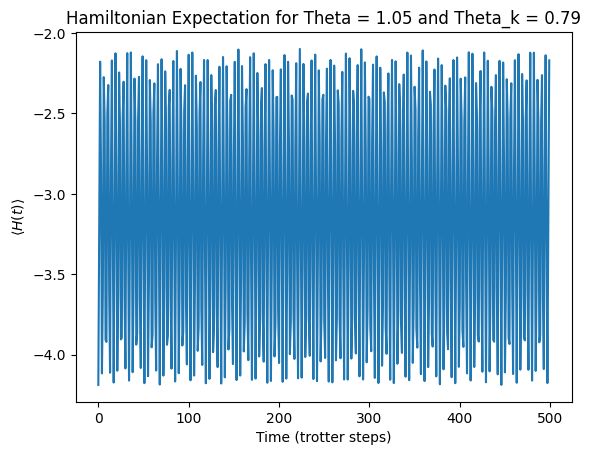

Rec time  for theta = 1.0471975511965976 and theta_k = 0.5235987755982988 is: 266


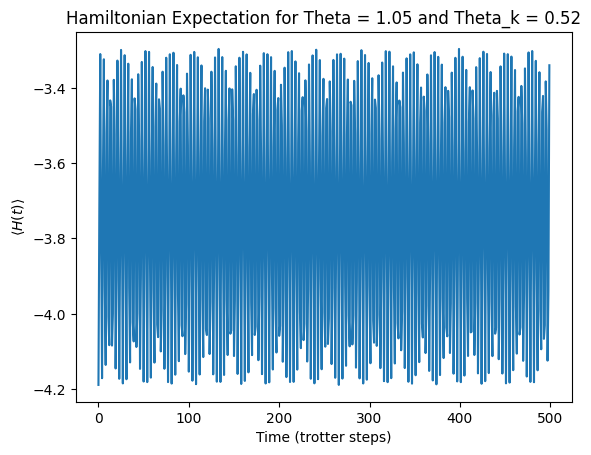

Rec time  for theta = 0.7853981633974483 and theta_k = 0.7853981633974483 is: 200


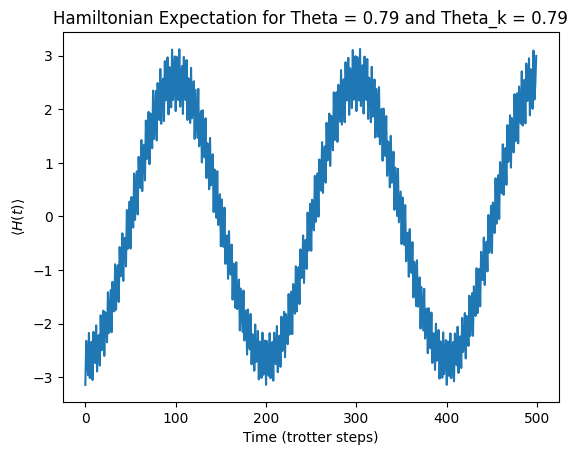

Rec time  for theta = 0.7853981633974483 and theta_k = 0.5235987755982988 is not found


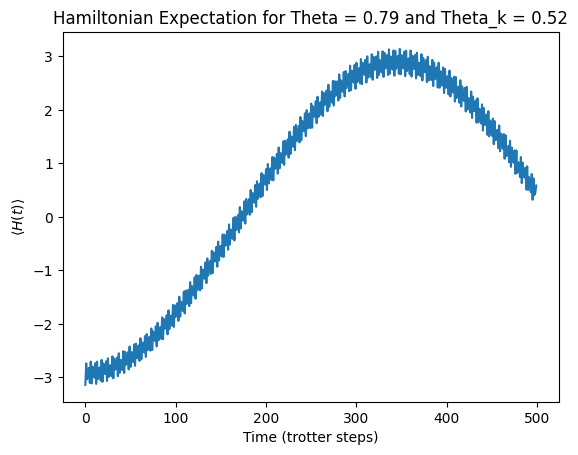

In [29]:
plot_hexp_50(super_qc_list_50)

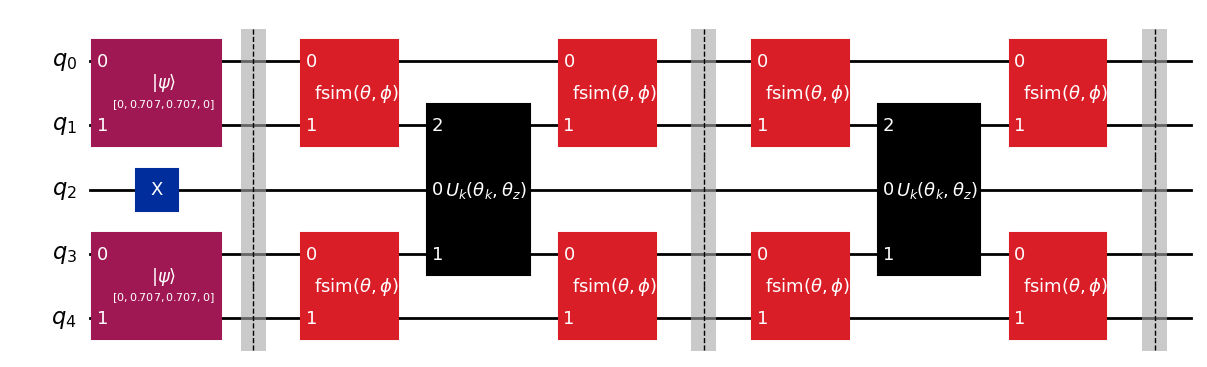

In [10]:
## Let us also define the translationally invariant state

def ts_state(N):
    str1 = ''
    str2 = ''
    for i in range(N):
        if i%2==0:
            str1 += '0'
            str2 += '1'
        else:
            str1 += '1'
            str2 += '0'
    state = (Statevector.from_label(str1) + Statevector.from_label(str2))/np.sqrt(2)
    return state

    

def ts_circuit(N,num_cl_bits=0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    ts_state_up = ts_state(N)
    ts_state_down = ts_state(N)
    #print(ts_state_down)
    qc.initialize(ts_state_up,range(N))
    qc.initialize(ts_state_down,range(N+1,2*N+1))
    return qc


def circuit_ts(N,pos_list, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = ts_circuit(N)
    else:
        qc = ts_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for i in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_ts(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl',style = gate_colours)

    

    


In [29]:
super_ts_list_20 = []
super_ts_list_50 = []

max_20 = 200
max_50 = 500
measured_bits =list(range(2*N + 1))
theta_list = [np.pi/3,np.pi/4]
theta_k_list = [np.pi/4,np.pi/6]


for theta in theta_list:
    for theta_k in theta_k_list:
        if theta_k > theta:
            continue
        else:
            theta_z = -theta_k
            qc_list = []
            qc_list_2 = []
            """for t in range(max_20):
                qc = circuit_ts(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list.append(qc)
            super_ts_list_20.append((qc_list,theta,theta_k))"""

            for t in range(max_50):
                qc = circuit_ts(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list_2.append(qc)
            super_ts_list_50.append((qc_list_2,theta,theta_k))

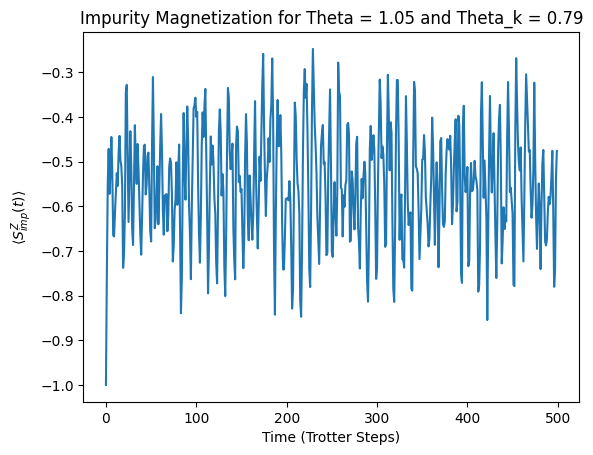

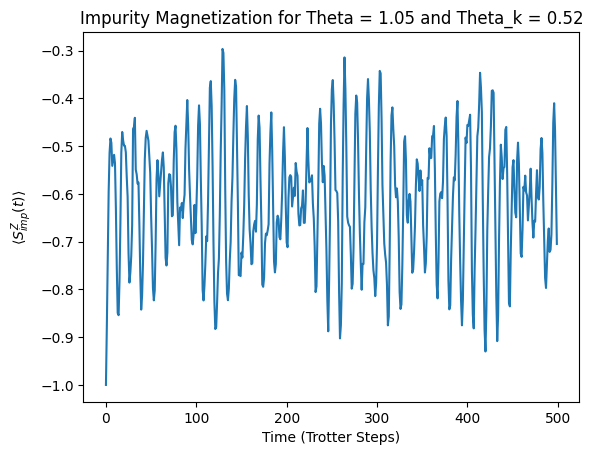

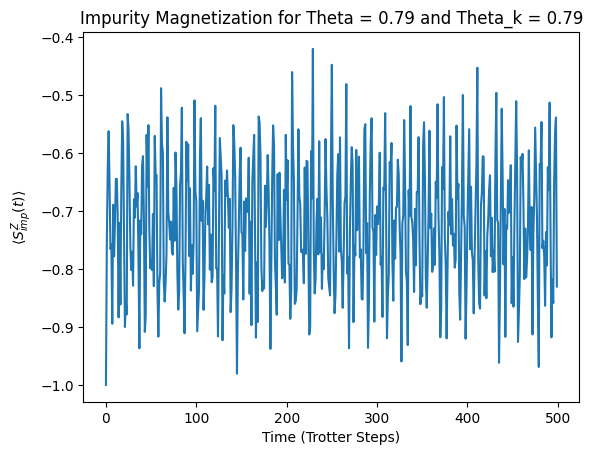

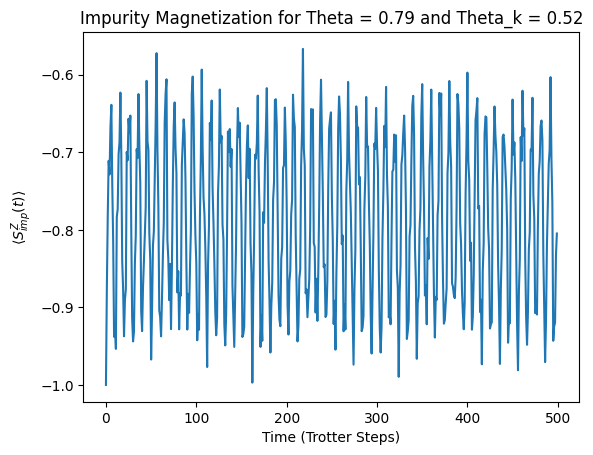

In [30]:
plot_mag_impurity_50(super_ts_list_50)

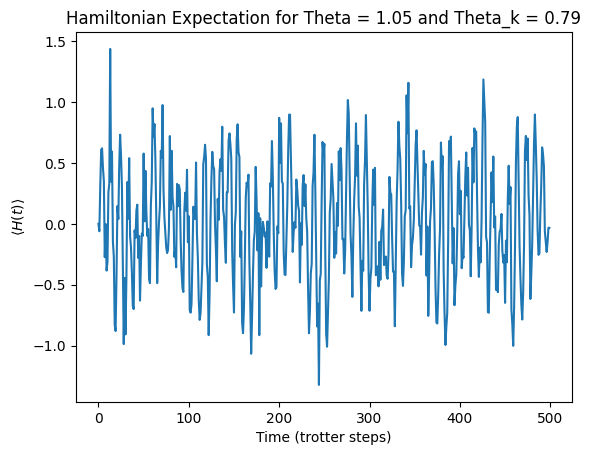

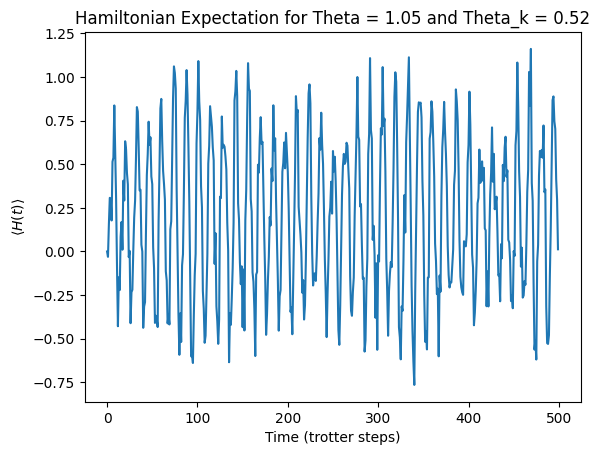

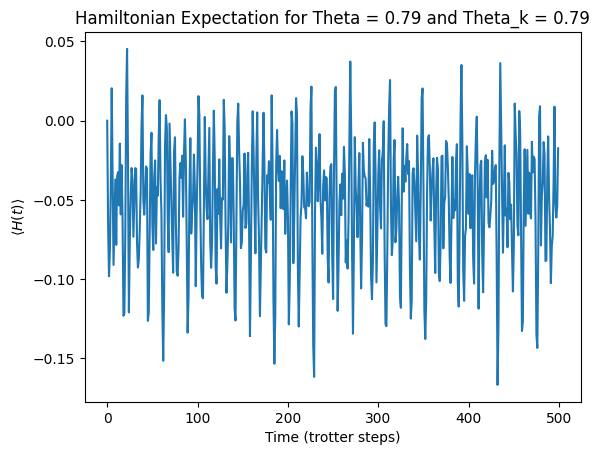

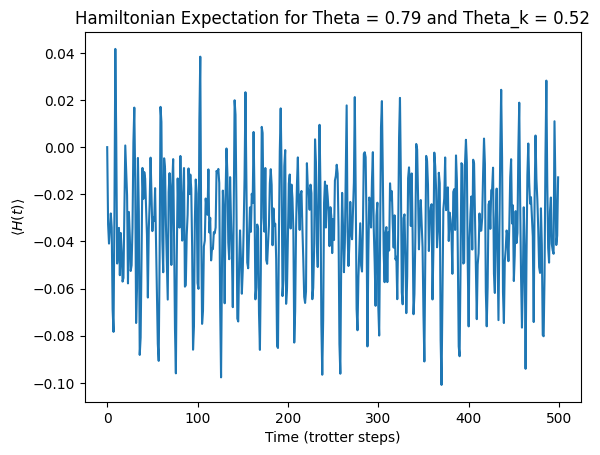

In [33]:
plot_hexp_50(super_ts_list_50)

In [20]:
def plot_compareTSFS(super_qc_list50, super_ts_list_50, theta,theta_k, color = 'r'):
    for i in range(len(theta_super_list)):
        if theta == theta_super_list[i][0] and theta_k == theta_super_list[i][1]:
            qc_list1 = super_qc_list50[i][0]
            qc_list2 = super_ts_list_50[i][0]
            imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*50
            job_1 = estimator.run(qc_list1,imp_observables,shots = None)
            job_2 = estimator.run(qc_list2,imp_observables,shots = None)
            expectation_list_1 = list(job_1.result().values)
            expectation_list_2 = list(job_2.result().values)
            plt.plot(range(50),expectation_list_1,color + "-",label = r'FS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")
            plt.plot(range(50),expectation_list_2,color + "--",label = r'TS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")
            

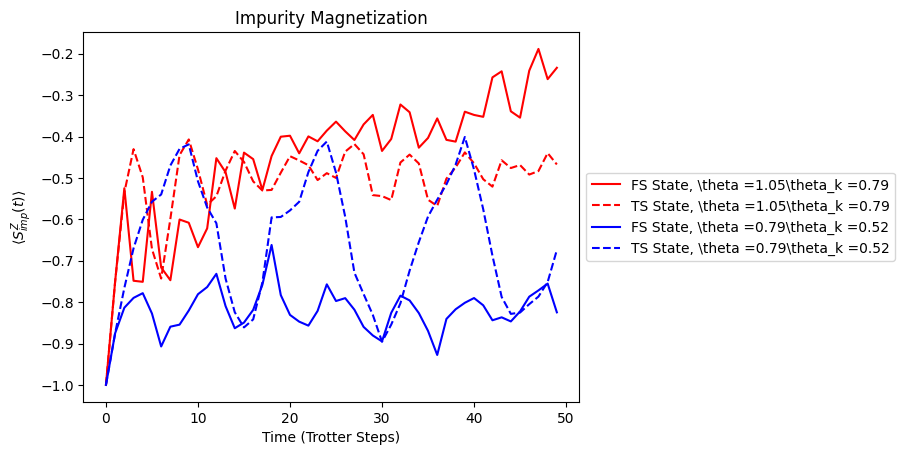

In [21]:
plot_compareTSFS(super_qc_list_50,super_ts_list_50,np.pi/3,np.pi/4,'r')
plot_compareTSFS(super_qc_list_50,super_ts_list_50,np.pi/4,np.pi/6,'b')

plt.title(f'Impurity Magnetization')
plt.xlabel('Time (Trotter Steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
def plot_compareTSFS_h(super_qc_list50, super_ts_list_50, theta,theta_k, color = 'r'):
    for i in range(len(theta_super_list)):
        if theta == theta_super_list[i][0] and theta_k == theta_super_list[i][1]:
            qc_list1 = super_qc_list50[i][0]
            qc_list2 = super_ts_list_50[i][0]

            h_analytical = [H_t + H_k]*50
        #print("Operator obtained from circuit")
            
            job_1 = estimator.run(qc_list1,h_analytical,shots = None)
            job_2 = estimator.run(qc_list2,h_analytical,shots = None)
            expectation_list_1 = list(job_1.result().values)
            expectation_list_2 = list(job_2.result().values)
            plt.plot(range(50),expectation_list_1,color + "-",label = r'FS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")
            plt.plot(range(50),expectation_list_2,color + "--",label = r'TS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")

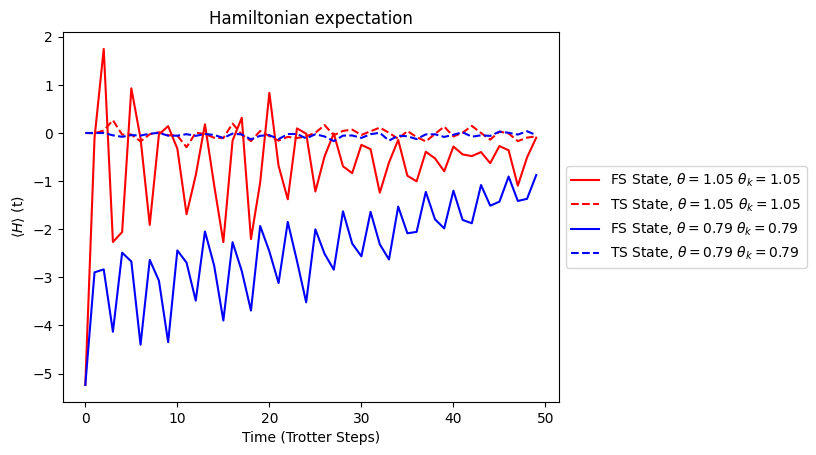

In [25]:
plot_compareTSFS_h(super_qc_list_50,super_ts_list_50,np.pi/3,np.pi/3,'r')
plot_compareTSFS_h(super_qc_list_50,super_ts_list_50,np.pi/4,np.pi/4,'b')

plt.title(f'Hamiltonian expectation')
plt.xlabel('Time (Trotter Steps)')
plt.ylabel(r'$\langle H \rangle$ (t)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

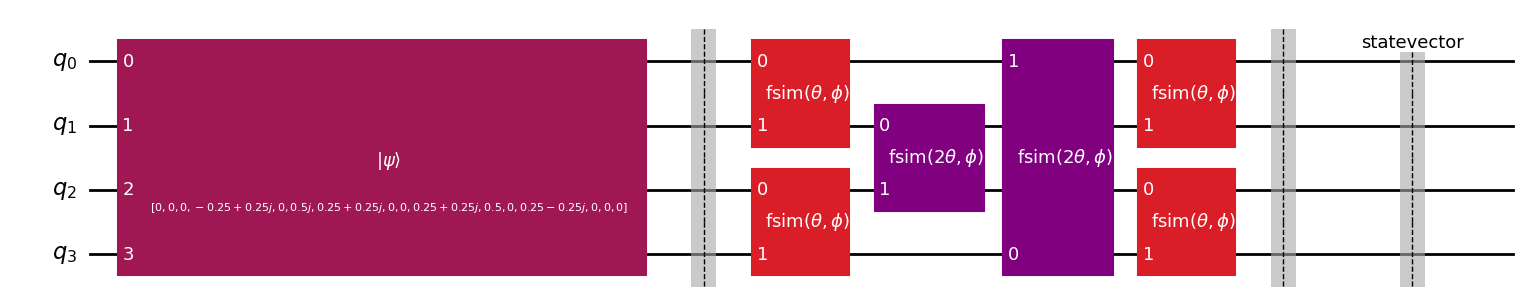

In [29]:
## Now we will run only the TS state on the periodic free fermion circuit and analyse the results for recurrence of <h_t>
N = 4
# Let us try a more symmetrised version with a ring circuit
fermi_state1 = fermi_state(N)
ts_state1 = ts_state(N)

num_qubits = N #for this circuit

angles  = [np.pi/4,0,0]

def circuit_sym(num_qubits, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.initialize(fermi_state1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim_sym(qc,angles)
        if trotter_barriers:
            qc.barrier()

    qc.save_statevector()  #this is to check the statevector after a fixed number of trotter steps
    return qc

def add_fsim_sym(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta/2,phi,beta)
    fsim2 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    qc.unitary(fsim2,[qc.num_qubits-1,0],label = r'fsim$(2\theta,\phi)$')

    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

trotter_steps = 1

gate_colours = {
    "displaycolor": {
        r'fsim$(2\theta,\phi)$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(\theta,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$U_{k}(\theta_k,\theta_z)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}


qc = circuit_sym(num_qubits,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl', style=gate_colours)

In [30]:
Ht_new = 0
for i in range(N-1):
        Ht_new += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(N-i-2)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(N-i-2)))

super_ff_list = []

for theta in theta_list:
        angles = [theta,0,0]
        qc_list_3 = []
        """for t in range(max_20):
                qc = circuit_ts(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list.append(qc)
            super_ts_list_20.append((qc_list,theta,theta_k))"""
        for t in range(max_50):
                qc = circuit_sym(N, t, angles,num_cl_bits = 0, trotter_barriers = True)
                #qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list_3.append(qc)
        super_ff_list.append((qc_list_3,theta))


In [31]:
def plot_hexp_ff(super_ff_list):
    for i in range(len(super_ff_list)):
        theta = super_ff_list[i][1]
        #theta_k = super_qc_list_50[i][2]
        qc_list = super_ff_list[i][0]

        Ht_new = 0
        #for i in range(N-1):
         #       Ht_new += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(N-i-2)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(N-i-2)))
        j = 0  #take value between 0 to N - 1
        Ht_new = 0.5*(SparsePauliOp('I'*(j) + 'I' + 'I'*(N-j-1)) + SparsePauliOp('I'*(j) + 'Z' + 'I'*(N-j-1)))
        print("Ht_new:", Ht_new)
        h_analytical = [Ht_new]*500

        job_1 = estimator.run(qc_list,h_analytical,shots = None)
        expectation_list_1 = list(job_1.result().values)
        c = 0
        for i in range(1,500):
            if abs(expectation_list_1[i]  - expectation_list_1[0]) <= 1e-3:
                c = 1
                print (f"Rec time  for theta = {theta} is:",i)
        if c == 0:
            print(f"Rec time  for theta = {theta} is not found")
        
        plt.plot(range(500),expectation_list_1,label = 'Total Hamiltonian analytical')
        plt.xlabel('Time (trotter steps)')
        plt.ylabel(f'Occupation number of site {j}')
        plt.title(f'FF Hamiltonian Expectation for Theta = {round(theta,2)}')
        plt.show()


    


Ht_new: SparsePauliOp(['IIII', 'ZIII'],
              coeffs=[0.5+0.j, 0.5+0.j])
Rec time  for theta = 1.0471975511965976 is not found


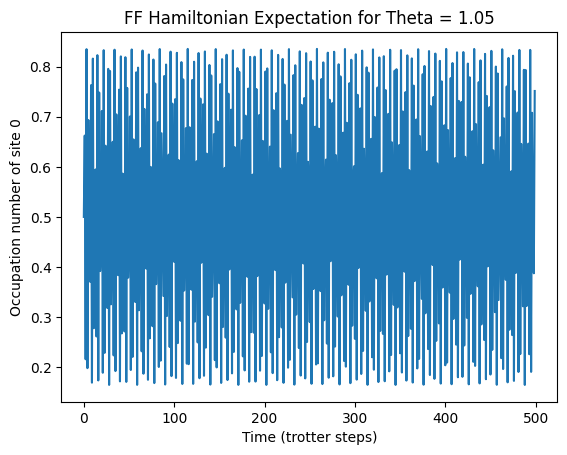

Ht_new: SparsePauliOp(['IIII', 'ZIII'],
              coeffs=[0.5+0.j, 0.5+0.j])
Rec time  for theta = 0.7853981633974483 is: 3
Rec time  for theta = 0.7853981633974483 is: 6
Rec time  for theta = 0.7853981633974483 is: 9
Rec time  for theta = 0.7853981633974483 is: 12
Rec time  for theta = 0.7853981633974483 is: 15
Rec time  for theta = 0.7853981633974483 is: 18
Rec time  for theta = 0.7853981633974483 is: 21
Rec time  for theta = 0.7853981633974483 is: 24
Rec time  for theta = 0.7853981633974483 is: 27
Rec time  for theta = 0.7853981633974483 is: 30
Rec time  for theta = 0.7853981633974483 is: 33
Rec time  for theta = 0.7853981633974483 is: 36
Rec time  for theta = 0.7853981633974483 is: 39
Rec time  for theta = 0.7853981633974483 is: 42
Rec time  for theta = 0.7853981633974483 is: 45
Rec time  for theta = 0.7853981633974483 is: 48
Rec time  for theta = 0.7853981633974483 is: 51
Rec time  for theta = 0.7853981633974483 is: 54
Rec time  for theta = 0.7853981633974483 is: 57
Rec time  

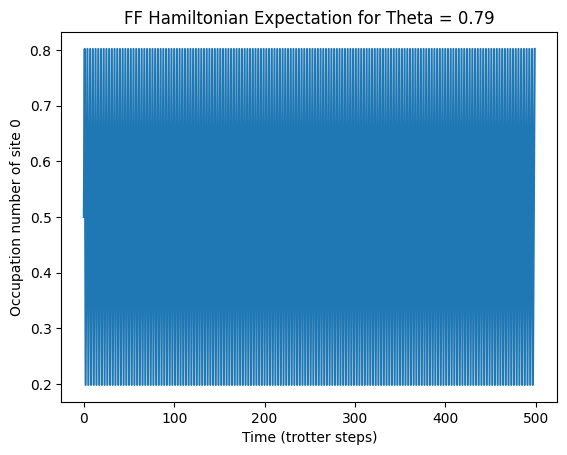

In [32]:
plot_hexp_ff(super_ff_list)